# The big kahuna

## First model: Linear Regression

In [76]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
# current_palette = sns.color_palette("Paired")
sns.set_palette(sns.color_palette("Set1"))
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
sns.set_context(rc={"lines.linewidth": 2.5})

lr = LinearRegression()

RSEED = 100

### Bin the Data by Lift Cost
We need to first bin the data by lift rate

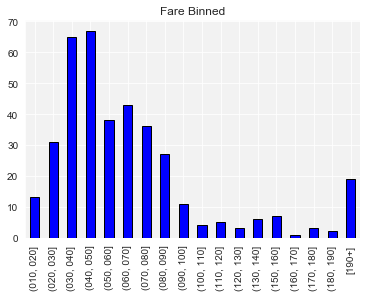

In [100]:
data = pd.read_csv('SkiResort_Combined_test.csv')
# data.describe()
data['fare-bin'] = pd.cut(data['adult day pass'], bins = list(range(10, 200, 10))).astype(str)

# Visualize the bins
# Uppermost bin
data.loc[data['fare-bin'] == 'nan', 'fare-bin'] = '[190+]'

# # Adjust bin so the sorting is correct
# data.loc[data['fare-bin'] == '(0, 10]', 'fare-bin'] = '(000, 010]'
data.loc[data['fare-bin'] == '(10, 20]', 'fare-bin'] = '(010, 020]'
data.loc[data['fare-bin'] == '(20, 30]', 'fare-bin'] = '(020, 030]'
data.loc[data['fare-bin'] == '(30, 40]', 'fare-bin'] = '(030, 040]'
data.loc[data['fare-bin'] == '(40, 50]', 'fare-bin'] = '(040, 050]'
data.loc[data['fare-bin'] == '(50, 60]', 'fare-bin'] = '(050, 060]'
data.loc[data['fare-bin'] == '(60, 70]', 'fare-bin'] = '(060, 070]'
data.loc[data['fare-bin'] == '(70, 80]', 'fare-bin'] = '(070, 080]'
data.loc[data['fare-bin'] == '(80, 90]', 'fare-bin'] = '(080, 090]'
data.loc[data['fare-bin'] == '(90, 100]', 'fare-bin'] = '(090, 100]'


# Bar plot of value counts
data['fare-bin'].value_counts().sort_index().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Fare Binned');

### Get rid of bins without enough data

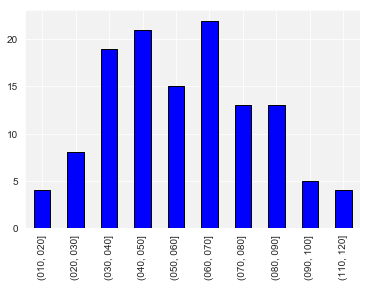

In [101]:
data = data.dropna(subset=['drop (m)','AVG_GOODDAYS','runCount_x'])
count = data['fare-bin'].value_counts()
bad = list(count[data['fare-bin'].value_counts() < 3].index)
for ii in bad:
    data = data[data['fare-bin'] != ii]
data['fare-bin'].value_counts().sort_index().plot.bar(color = 'b', edgecolor = 'k');


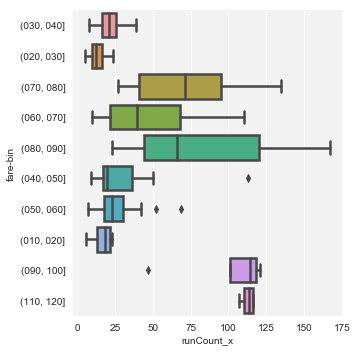

In [102]:
import seaborn as sns
sns.catplot(x="runCount_x", y="fare-bin", kind="box", data=data);


In [103]:
data['fare-bin'].value_counts()

(060, 070]    22
(040, 050]    21
(030, 040]    19
(050, 060]    15
(080, 090]    13
(070, 080]    13
(020, 030]     8
(090, 100]     5
(010, 020]     4
(110, 120]     4
Name: fare-bin, dtype: int64

### Scale features

In [104]:
# scale the vertical drop by 10 so that is closer to the values of the other features
data['drop (m)'] = data['drop (m)']/10

## Create the training and validation sets

In [105]:
# Split data
X_train, X_valid, y_train, y_valid = train_test_split(data, np.array(data['adult day pass']), 
                                                      stratify = data['fare-bin'],
                                                      random_state = RSEED, test_size = 0.5)

### Train with the features now

In [106]:
lr.fit(X_train[['long_x', 'drop (m)', 'AVG_GOODDAYS']], y_train)

print('Intercept', round(lr.intercept_, 4))
print('long_x coef: ', round(lr.coef_[0], 4), 
      '\tlong_x coef:', round(lr.coef_[1], 4),
      '\tAVG_GOODDAYS coef:', round(lr.coef_[2], 4))

Intercept 74.4575
long_x coef:  0.2042 	long_x coef: 0.3262 	AVG_GOODDAYS coef: -0.1374


#### Score Model

Score the model via two metrics:

* __Root mean squared error__: the metric used by the competition
* __Mean absolute percentage error__: the average percentage error of the predictions

In [107]:
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

def metrics(train_pred, valid_pred, y_train, y_valid):
    """Calculate metrics:
       Root mean squared error and mean absolute percentage error"""
    
    # Root mean squared error
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    
    # Calculate absolute percentage error
    train_ape = abs((y_train - train_pred) / y_train)
    valid_ape = abs((y_valid - valid_pred) / y_valid)
    
    # Account for y values of 0
    train_ape[train_ape == np.inf] = 0
    train_ape[train_ape == -np.inf] = 0
    valid_ape[valid_ape == np.inf] = 0
    valid_ape[valid_ape == -np.inf] = 0
    
    train_mape = 100 * np.mean(train_ape)
    valid_mape = 100 * np.mean(valid_ape)
    
    return train_rmse, valid_rmse, train_mape, valid_mape

def evaluate(model, features, X_train, X_valid, y_train, y_valid):
    """Mean absolute percentage error"""
    
    # Make predictions
    train_pred = model.predict(X_train[features])
    valid_pred = model.predict(X_valid[features])
    
    # Get metrics
    train_rmse, valid_rmse, train_mape, valid_mape = metrics(train_pred, valid_pred,
                                                             y_train, y_valid)
    
    print(f'Training:   rmse = {round(train_rmse, 2)} \t mape = {round(train_mape, 2)}')
    print(f'Validation: rmse = {round(valid_rmse, 2)} \t mape = {round(valid_mape, 2)}')

In [108]:
evaluate(lr, ['long_x', 'drop (m)', 'AVG_GOODDAYS'], 
        X_train, X_valid, y_train, y_valid)

Training:   rmse = 18.03 	 mape = 28.25
Validation: rmse = 20.3 	 mape = 36.15


### Naive Baseline

Compare these predictions to a naive guess. For now use the average value of the target in the training data.

In [109]:
train_mean = y_train.mean()

# Create list of the same prediction for every observation
train_preds = [train_mean for _ in range(len(y_train))]
valid_preds = [train_mean for _ in range(len(y_valid))]

tr, vr, tm, vm = metrics(train_preds, valid_preds, y_train, y_valid)

print(f'Baseline Training:   rmse = {round(tr, 2)} \t mape = {round(tm, 2)}')
print(f'Baseline Validation: rmse = {round(vr, 2)} \t mape = {round(vm, 2)}')

Baseline Training:   rmse = 22.4 	 mape = 40.26
Baseline Validation: rmse = 23.36 	 mape = 43.51


### Try scaling the features so that they are similar numbers
Probably need to divide at least the drop by 10 or more

In [110]:
# set the features
features = ['lat_x', 'drop (m)', 'AVG_GOODDAYS','runCount_x']

### Try with more Features

In [111]:
lr.fit(X_train[features], y_train)
# print('Intercept', round(lr.intercept_, 4))
# print('long_x coef: ', round(lr.coef_[0], 4), 
#       '\tlong_x coef:', round(lr.coef_[1], 4),
#       '\tAVG_COLDDAYS coef:', round(lr.coef_[2], 4),
#      '\trunCount coef:', round(lr.coef_[3], 4))
evaluate(lr, features, 
         X_train, X_valid, y_train, y_valid)

Training:   rmse = 12.06 	 mape = 19.35
Validation: rmse = 14.6 	 mape = 25.29


In [112]:
# Get rid of yearly temp data
cold_cols = [col for col in data.columns if '_COLD' in col]
# for ii in cold_cols:
#     data = data.drop(ii)
data = data.drop(columns=cold_cols)
hot_cols = [col for col in data.columns if '_HOT' in col]
data = data.drop(columns=hot_cols)

bad_cols = [col for col in data.columns if '_y' in col]
data = data.drop(columns=bad_cols)

In [113]:
corrdata = data[['lat_x','long_x','runCount_x','liftCount_x','skiableAcreage_x','longestRun_x','adult day pass','drop (m)','AVG_GOODDAYS']]
list(corrdata)

['lat_x',
 'long_x',
 'runCount_x',
 'liftCount_x',
 'skiableAcreage_x',
 'longestRun_x',
 'adult day pass',
 'drop (m)',
 'AVG_GOODDAYS']

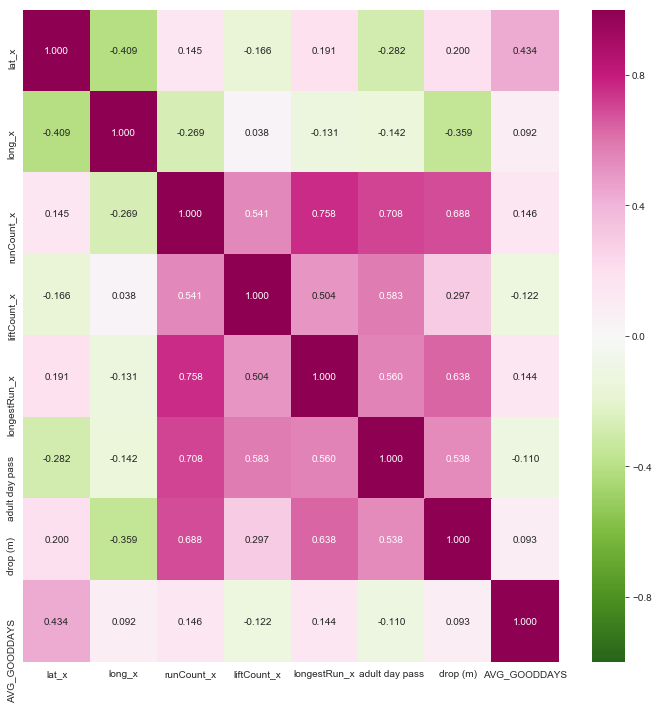

In [114]:
corrs = corrdata.corr()

plt.figure(figsize = (12, 12))
sns.heatmap(corrs, annot = True, vmin = -1, vmax = 1, fmt = '.3f', cmap=plt.cm.PiYG_r);

## Implement Random Forest Model

In [115]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest
random_forest = RandomForestRegressor(n_estimators = 20, max_depth = 20, 
                                      max_features = None, oob_score = True, 
                                      bootstrap = True, verbose = 1, n_jobs = -1)

# Train on data
random_forest.fit(X_train[features], y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
           oob_score=True, random_state=None, verbose=1, warm_start=False)

In [116]:
evaluate(random_forest, features,
         X_train, X_valid, y_train, y_valid)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    0.0s finished


Training:   rmse = 4.17 	 mape = 6.57
Validation: rmse = 14.75 	 mape = 24.23


Good news is that our training error dropped a ton but the bad news is that hte validation error stayed the same.

In this instance I think the issue is that we don't have enough data ... 

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    0.0s finished


Text(0.5, 0, 'Adult Lift Ticket')

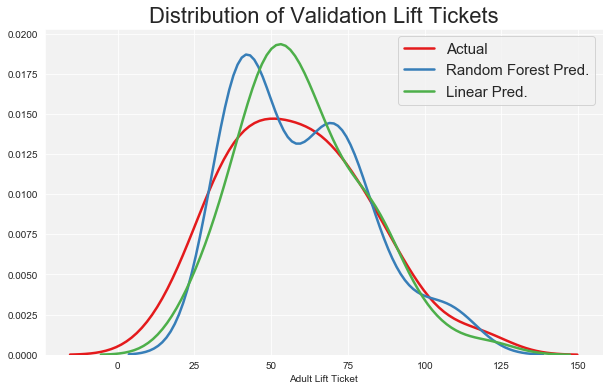

In [120]:
valid_preds = random_forest.predict(X_valid[features])
valid_lr = lr.predict(X_valid[features])
# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
# sns.set()

plt.figure(figsize = (10, 6))
ax=sns.kdeplot(y_valid, label = 'Actual')
sns.kdeplot(valid_preds, label = 'Random Forest Pred.')
sns.kdeplot(valid_lr, label = 'Linear Pred.')
plt.legend(prop = {'size': 15})
plt.title("Distribution of Validation Lift Tickets",size=22);
plt.xlabel('Adult Lift Ticket')